# Geomedians

**Notebook currently compatible with the `NCI` environment only**

This is because the `datacube-stats` module is not yet reconfigured for the Sandbox environment. 

### Background

Individual remote sensing images can be affected by noisy data, including clouds, cloud shadow, and haze. To produce cleaner images that can be compared more easily across time, we can create 'summary' images or `composites` that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. One approach to doing this is to create a [Geomedian](https://github.com/daleroberts/hdmedians). A `geomedian` is based on a high-dimensional statistic called the `geometric median` [(Small, C. G. 1990)](https://www.jstor.org/stable/1403809), which effectively trades a temporal stack of poor quality observations for a single high-quality pixel composite with reduced spatial noise.  In contrast to a standard median, a geomedian maintains the relationship between spectral bands [(Roberts et al. 2017)](https://ieeexplore.ieee.org/abstract/document/8004469). This allows us to conduct further analysis on the composite images just as we would on the original satellite images (e.g by allowing the calculation of common band indices like NDVI).

### Description
In this notebook we will take of time series of noisy satellite images collected over a year and calculate the annual geomedian composite  


### Technical details
* **Products used:** `s2a_ard_granule`, `s2b_ard_granule`
* **Analyses used:** Geomedian composites
* **Special requirements:**

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
from datacube_stats.statistics import GeoMedian
import matplotlib.pyplot as plt
import sys

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb

### Connect to the datacube
Give your datacube app a unique name that is consistent with the purpose of the notebook.

In [2]:
dc = datacube.Datacube(app="geomedians")

## Load Sentinel 2 data from the datacube

Here we are loading in a timeseries of Sentinel 2 satellite images through the datacube API using the [load_ard](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Frequently_used_code/Using_load_ard.ipynb) function. This will provide us with some data to work with.

In [3]:
# Create a query object
query = {
    'x': (153.35, 153.50),
    'y': (-28.80, -28.95),
    'time': ('2018-01', '2018-12'),
    'measurements': ['nbart_green',
                     'nbart_red',
                     'nbart_blue'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data
ds = load_ard(dc=dc, 
              products=['s2a_ard_granule', 's2b_ard_granule'], 
              **query)

# Print output data
print(ds)

Loading s2a_ard_granule data
    Applying pixel quality mask
Loading s2b_ard_granule data
    Applying pixel quality mask
Combining and sorting data
    Masking out invalid values
    Returning 70 observations 
<xarray.Dataset>
Dimensions:      (time: 70, x: 570, y: 634)
Coordinates:
  * y            (y) float64 -3.3e+06 -3.3e+06 ... -3.319e+06 -3.319e+06
  * x            (x) float64 2.047e+06 2.047e+06 ... 2.064e+06 2.064e+06
  * time         (time) datetime64[ns] 2018-01-01T23:52:39.027000 ... 2018-12-27T23:52:39.024000
Data variables:
    nbart_green  (time, y, x) float32 nan nan nan nan ... 250.0 202.0 246.0
    nbart_red    (time, y, x) float32 nan nan nan nan ... 180.0 138.0 85.0 149.0
    nbart_blue   (time, y, x) float32 nan nan nan nan ... 327.0 278.0 326.0
Attributes:
    crs:      EPSG:3577


## Plot true colour timesteps

To visualise the data, use the pre-loaded rgb utility function to plot a true colour image for a series of timesteps. White areas indicate where clouds or other invalid pixels in the image have been masked.

The code below will plot the first 4, and last 4 timesteps of the time series we just loaded. 

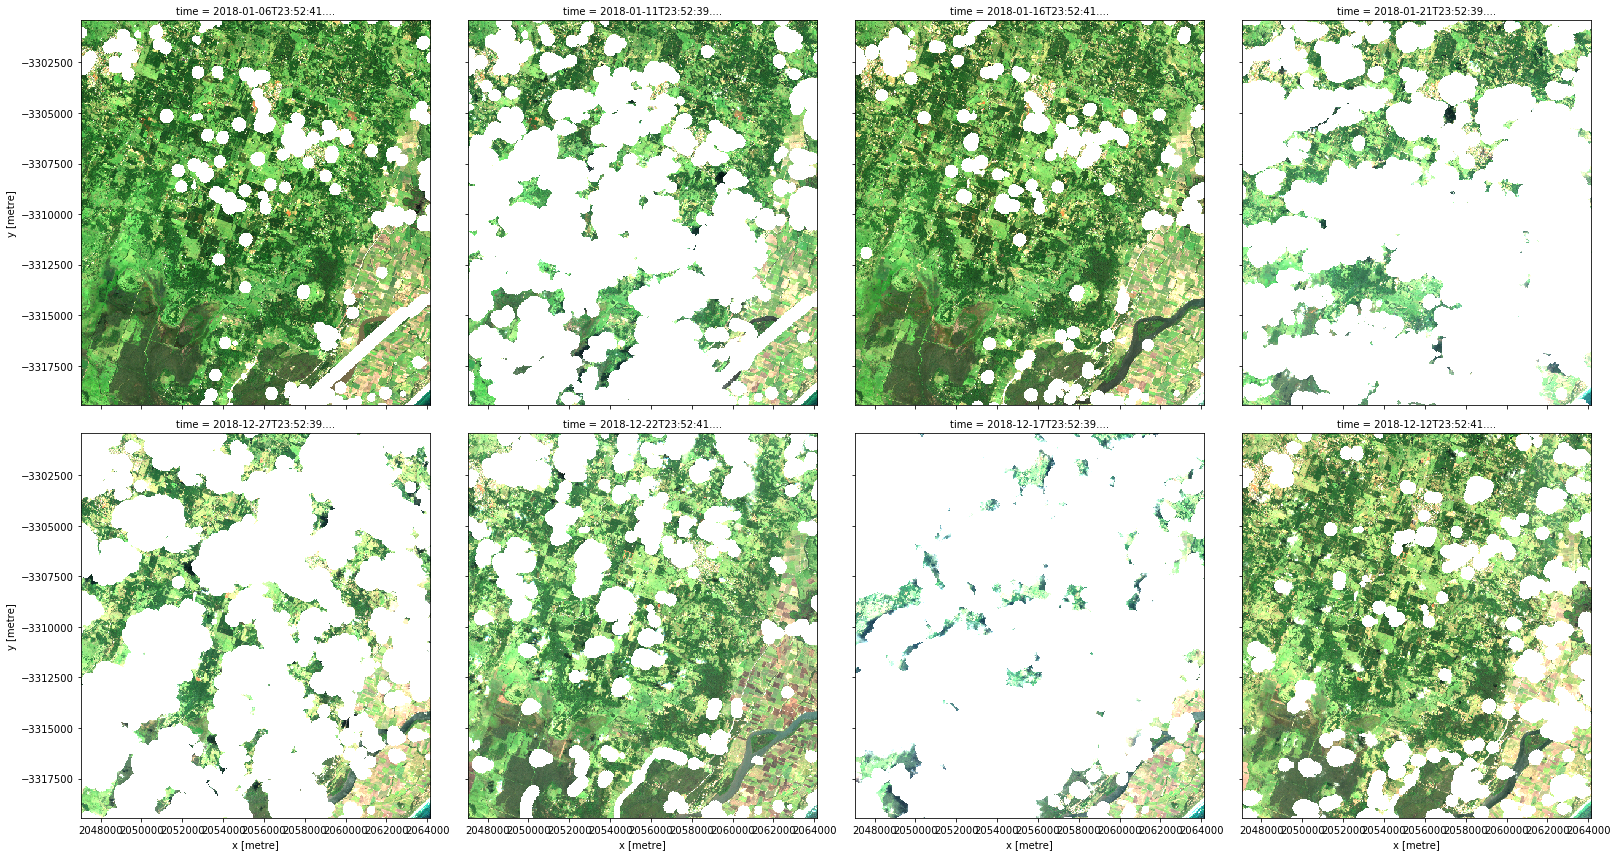

In [16]:
# Set the timesteps to visualise, this
timesteps = [1,2,3,4,-1,-2,-3,-4]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps,
    percentile_stretch=(0.00, 0.95))

## Generate a Geomedian

As you can see above, most satellite images will have some areas masked out due to clouds or some other interference between the satellite and the ground.  Generating a geomedian composite will combine all the observations in our `xarray.Dataset` into a single, complete (or near complete) image.


In [5]:
#compute geomedian using all observations in the dataset
geomedian = GeoMedian().compute(ds)

If we print our result, you will see that the `time dimension` has now been removed and we are left with a single image that represents the geometric median of all the satellite images in our intial time series.

In [6]:
print(geomedian)

<xarray.Dataset>
Dimensions:      (x: 570, y: 634)
Coordinates:
  * y            (y) float64 -3.3e+06 -3.3e+06 ... -3.319e+06 -3.319e+06
  * x            (x) float64 2.047e+06 2.047e+06 ... 2.064e+06 2.064e+06
Data variables:
    nbart_green  (y, x) float32 785.4065 812.5953 ... 325.29797 324.61264
    nbart_red    (y, x) float32 757.37256 755.6008 ... 159.50264 158.18187
    nbart_blue   (y, x) float32 511.48798 522.9589 ... 367.49963 366.0602
Attributes:
    crs:      EPSG:3577


## Plot the gemedian composite

When we plot the result, we can see that the geomedian image is much more complete than any of the individual images. Further, we can also use this data in downstream analysis as the relationships between the spectral bands is maintained by the geometric median statistic.


**NOTE:** You may notice that there are still some holes in our geomedian composite, this is largely due to [Fmask](https://github.com/GERSL/Fmask), the current default cloud masking algorithm, being overzealous in removing pixels when masking Sentinel 2 satellite images. This is a known limitation of our current cloud masking approach and a new method for cloud masking of Sentinel 2 data is nearly ready to be deployed.

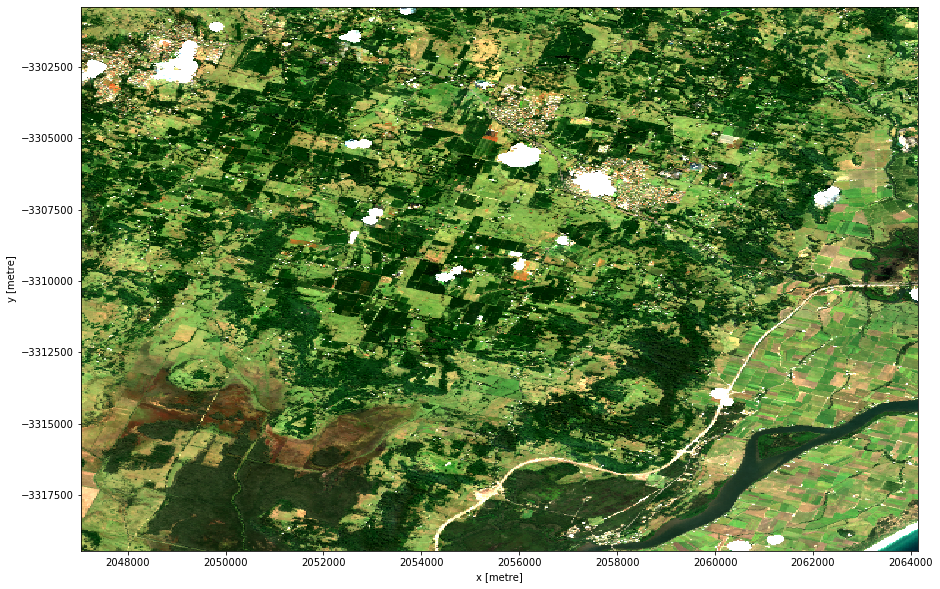

In [7]:
# Plot the result
bands = ['nbart_red', 'nbart_green', 'nbart_blue']
da = geomedian[bands].to_array()
img = da.plot.imshow(robust=True, aspect=None,
                     size=10)

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [8]:
print(datacube.__version__)

1.7


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)